In [7]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import pickle

from DR_analysis_utils import Session

%matplotlib notebook

In [3]:
#session paths list
main_paths = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",   
]


In [ ]:
full_video_path=r"D:\DR Pilot Data\DR_trimmed_full_videos"

save_path=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-10-12-avg-frame-motion-aud-vis-blocks"

prestim_time=0.2

#loop through sessions:
for path in main_paths[:]:
        
    print('loading sesssion: '+path)
    #load session
    session=Session(path=path)
    
    #load camera frames
    cam_frames_path = os.path.join(path,"camera_frames.pkl")
    with open(cam_frames_path, 'rb') as filepath:
        cam_frames=pickle.load(filepath)
        

    #load video
    _dir,vidfilename=os.path.split(glob.glob(os.path.join(path,"Behavior_*.mp4"))[0])
    vid_path = os.path.join(full_video_path,vidfilename[:-12]+'_trimmed.mp4')
    
    cap = cv2.VideoCapture(vid_path)
    framecount = 0
    vistrialcount = 0
    audtrialcount = 0
    trialframecount = 0
    
    fps, frames = cap.get(cv2.CAP_PROP_FPS), cap.get(cv2.CAP_PROP_FRAME_COUNT)
    w_frame, h_frame = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    n_prestim_frames=int(fps*prestim_time)
    

    #find frame times for vis vs. aud blocks
    vis_block_prestim_frames=[]
    aud_block_prestim_frames=[]
    
    for tt,trial in session.trials.iterrows():
        trial_prestim_frames=np.arange(
            trial['trialStimStartFrame']-n_prestim_frames,
            trial['trialStimStartFrame']
        )
        
        if trial['trialstimRewarded']=='vis1':
            vis_block_prestim_frames.append(trial_prestim_frames)
        elif trial['trialstimRewarded']=='sound1':
            aud_block_prestim_frames.append(trial_prestim_frames)
            
    vis_block_prestim_frames=np.vstack(vis_block_prestim_frames)
    aud_block_prestim_frames=np.vstack(aud_block_prestim_frames)
    
    
    #pre-allocate arrays: frames and frame diffs
    vis_block_avg_prestim_frames=np.zeros((h_frame,w_frame,vis_block_prestim_frames.shape[0]),dtype=int)
    aud_block_avg_prestim_frames=np.zeros((h_frame,w_frame,aud_block_prestim_frames.shape[0]),dtype=int)
    
    vis_block_avg_prestim_motion=np.zeros((h_frame,w_frame,vis_block_prestim_frames.shape[0]),dtype=int)
    aud_block_avg_prestim_motion=np.zeros((h_frame,w_frame,aud_block_prestim_frames.shape[0]),dtype=int)
    
    temp_vis_block_frames=np.zeros((h_frame,w_frame,n_prestim_frames),dtype=int)
    temp_aud_block_frames=np.zeros((h_frame,w_frame,n_prestim_frames),dtype=int)
    
    #loop through frames, save frames we want to arrays + save diffs btwn frames (avg per trial)
    lastpct=0
    start_time=time.time()
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        # average arrays
        if ret==True:
            
            # Percentage of frames completed
            xx = framecount *100/frames
            xx=int(xx)
            if (xx%10==0)&(xx>lastpct):
                lastpct=xx
                elapsed_time=time.time()-start_time
                print(int(xx),'% complete; time elapsed:',np.round(elapsed_time,decimals=2))
            
            if vistrialcount < vis_block_prestim_frames.shape[0]:
                if framecount in vis_block_prestim_frames[vistrialcount,:]:
                    temp_vis_block_frames[:,:,trialframecount]=np.mean(frame,axis=2)
                    trialframecount+=1
                    if trialframecount>n_prestim_frames-1:
                        temp_avg_frame = np.mean(temp_vis_block_frames,axis=2)
                        temp_avg_mot = np.mean(np.diff(temp_vis_block_frames,axis=2),axis=2)

                        vis_block_avg_prestim_frames[:,:,vistrialcount]=temp_avg_frame
                        vis_block_avg_prestim_motion[:,:,vistrialcount]=temp_avg_mot

                        vistrialcount+=1
                        trialframecount=0
            
            if audtrialcount < aud_block_prestim_frames.shape[0]:
                if framecount in aud_block_prestim_frames[audtrialcount,:]:
                    temp_aud_block_frames[:,:,trialframecount]=np.mean(frame,axis=2)
                    trialframecount+=1
                    if trialframecount>n_prestim_frames-1:
                        temp_avg_frame = np.mean(temp_aud_block_frames,axis=2)
                        temp_avg_mot = np.mean(np.diff(temp_aud_block_frames,axis=2),axis=2)

                        aud_block_avg_prestim_frames[:,:,audtrialcount]=temp_avg_frame
                        aud_block_avg_prestim_motion[:,:,audtrialcount]=temp_avg_mot

                        audtrialcount+=1
                        trialframecount=0
            
        else:
            
            break
        
        
        framecount += 1
        
    elapsed_time=time.time()-start_time
    print('100% complete; time elapsed:',np.round(elapsed_time,decimals=2))    
    cap.release()
    
    #plot, save plots to disk
    
    #avg frames for each block
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(np.nanmean(vis_block_avg_prestim_frames,axis=2),cmap='Greys_r')
    ax[0].set_title(session.metadata['mouseID']+'-'+str(session.metadata['ephys_session_num'])+' visual blocks')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(np.nanmean(aud_block_avg_prestim_frames,axis=2),cmap='Greys_r')
    ax[1].set_title(session.metadata['mouseID']+'-'+str(session.metadata['ephys_session_num'])+' auditory blocks')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.tight_layout()
    figname=str(metadata['mouseID'])+'_'+str(metadata['ephys_session_num'])+'_avg_vis_vs_aud_block_frames.png'
    plt.savefig(os.path.join(save_path,figname), dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format='png', transparent=True, bbox_inches='tight', 
                pad_inches=0.1, metadata=None)
    
    
    #vis minus aud difference
    im_diff=np.nanmean(vis_block_avg_prestim_frames,axis=2)-np.nanmean(aud_block_avg_prestim_frames,axis=2)
    im_diff_min=np.min(im_diff)
    im_diff_max=np.max(im_diff)
    abs_max=np.max([np.abs(im_diff_min),np.abs(im_diff_max)])

    fig,ax=plt.subplots(1,1)
    im=ax.imshow(im_diff,cmap='bwr',vmin=-abs_max,vmax=abs_max)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(session.metadata['mouseID']+'-'+str(session.metadata['ephys_session_num'])+
                 ' avg frame diff btwn vis & aud blocks')
    fig.tight_layout()

    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3)
    cax = plt.axes([0.85, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('avg pixel diff (vis-aud)')
    
    figname=str(metadata['mouseID'])+'_'+str(metadata['ephys_session_num'])+'_vis_minus_aud_diff.png'
    plt.savefig(os.path.join(save_path,figname), dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format='png', transparent=True, bbox_inches='tight', 
                pad_inches=0.1, metadata=None)

    #save averages to disk -- hold off for now, ~1gb per session

loading sesssion: \\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed
10 % complete; time elapsed: 55.97
20 % complete; time elapsed: 101.37
30 % complete; time elapsed: 124.16
40 % complete; time elapsed: 149.15
50 % complete; time elapsed: 173.3


In [87]:
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-10-12-avg-frame-motion-aud-vis-blocks"
# np.save(os.path.join(savepath,'test.npy'),aud_block_avg_prestim_frames)

<IPython.core.display.Javascript object>


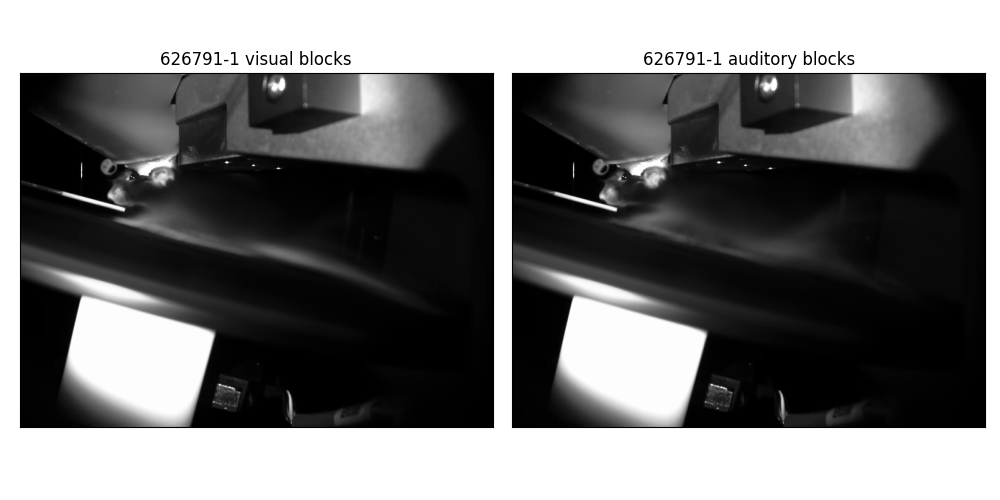

In [90]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(np.nanmean(vis_block_avg_prestim_frames,axis=2),cmap='Greys_r')
ax[0].set_title(session.metadata['mouseID']+'-'+str(session.metadata['ephys_session_num'])+' visual blocks')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(np.nanmean(aud_block_avg_prestim_frames,axis=2),cmap='Greys_r')
ax[1].set_title(session.metadata['mouseID']+'-'+str(session.metadata['ephys_session_num'])+' auditory blocks')
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()

<IPython.core.display.Javascript object>


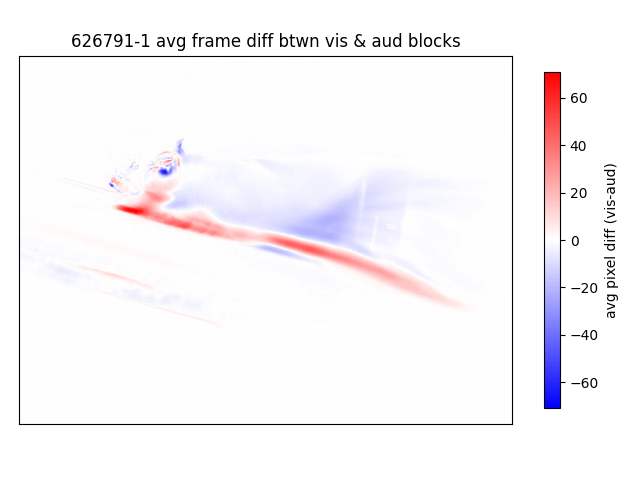

Text(0, 0.5, 'avg pixel diff (vis-aud)')

In [91]:
im_diff=np.nanmean(vis_block_avg_prestim_frames,axis=2)-np.nanmean(aud_block_avg_prestim_frames,axis=2)

im_diff_min=np.min(im_diff)
im_diff_max=np.max(im_diff)

abs_max=np.max([np.abs(im_diff_min),np.abs(im_diff_max)])

fig,ax=plt.subplots(1,1)
im=ax.imshow(im_diff,cmap='bwr',vmin=-abs_max,vmax=abs_max)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title(session.metadata['mouseID']+'-'+str(session.metadata['ephys_session_num'])+
             ' avg frame diff btwn vis & aud blocks')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3)
cax = plt.axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('avg pixel diff (vis-aud)')

<IPython.core.display.Javascript object>


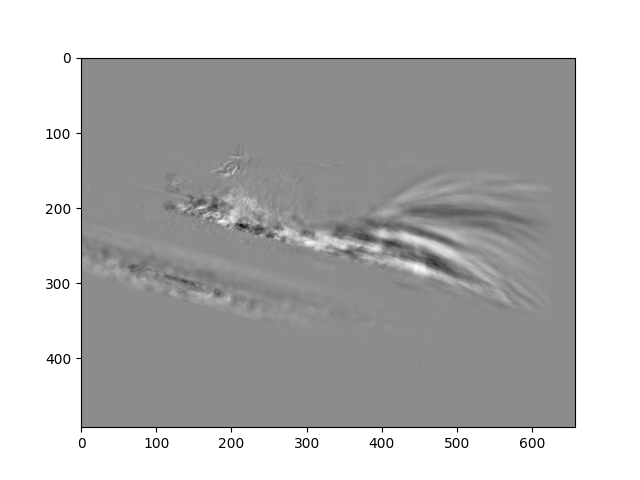

In [62]:
fig,ax=plt.subplots(1,1)
ax.imshow(np.nanmean(vis_block_avg_prestim_motion,axis=2),cmap='Greys_r')

<IPython.core.display.Javascript object>


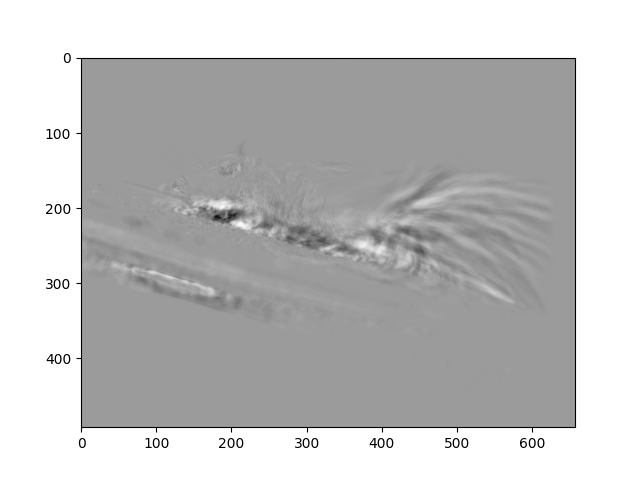

In [63]:
fig,ax=plt.subplots(1,1)
ax.imshow(np.nanmean(aud_block_avg_prestim_motion,axis=2),cmap='Greys_r')

<IPython.core.display.Javascript object>


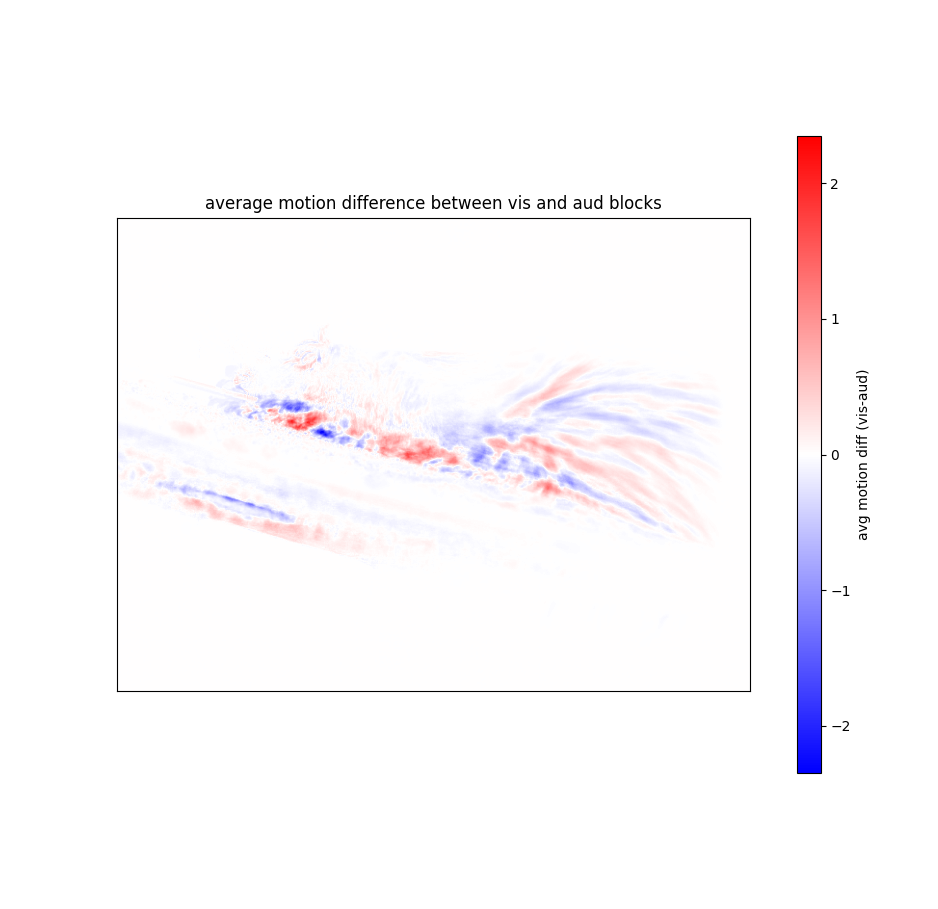

Text(0, 0.5, 'avg motion diff (vis-aud)')

In [82]:
im_diff=np.nanmean(vis_block_avg_prestim_motion,axis=2)-np.nanmean(aud_block_avg_prestim_motion,axis=2)

im_diff_min=np.min(im_diff)
im_diff_max=np.max(im_diff)

abs_max=np.max([np.abs(im_diff_min),np.abs(im_diff_max)])

fig,ax=plt.subplots(1,1)
im=ax.imshow(im_diff,cmap='bwr',vmin=-abs_max,vmax=abs_max)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('average motion difference between vis and aud blocks')

fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3)
cax = plt.axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('avg motion diff (vis-aud)')


In [16]:
vis_block_prestim_frames

array([   421,    422,    423, ..., 180667, 180668, 180669])

In [10]:
session.trials.columns

Index(['trialStartFrame', 'trialStimID', 'trialstimRewarded', 'trial_response',
       'trial_rewarded', 'trial_sound_dur', 'trial_vis_stim_dur',
       'vis_go_trials', 'vis_nogo_trials', 'vis_hit_trials',
       'vis_false_alarm_trials', 'vis_miss_trials',
       'vis_correct_reject_trials', 'vis_autoreward_trials', 'aud_go_trials',
       'aud_nogo_trials', 'aud_hit_trials', 'aud_false_alarm_trials',
       'aud_miss_trials', 'aud_correct_reject_trials', 'aud_autoreward_trials',
       'catch_trials', 'catch_resp_trials', 'trialStimStartFrame',
       'stimStartTime', 'stimLatency', 'trial_stim_dur', 'avg_run_speed'],
      dtype='object')